# Stage 6 — Captain Policy

## Purpose

This notebook documents the **complete lifecycle** of building a captain selection policy:

1. **6a — Original Policy**: Select captain using `score = p_play × mu_points`
2. **6b — Baseline Comparison**: Test against naive alternatives
3. **6c — Policy Revision**: Apply evidence-based correction

Evaluation uses **regret**, not prediction accuracy. Regret = optimal_points − chosen_points. Non-zero regret is expected — we cannot predict which player will haul.

This notebook tells the story: *hypothesis → test → learn → fix*.

---

# Part 6a — Original Policy

## Hypothesis

The captain selection score should account for **both upside and availability**:

```
score = p_play × mu_points
```

- `p_play` — probability of playing (from Stage 5 beliefs)
- `mu_points` — expected points given playing (from Stage 5 beliefs)

This should protect against picking players who might be rotated.

## Inputs & Outputs

| Artifact | Description |
|----------|-------------|
| `beliefs.csv` | Belief estimates (p_play, mu_points) |
| `targets.csv` | Ground-truth realized points |
| `evaluation_captain.csv` | Captain choices and regret per GW |

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load frozen artifacts
eval_df = pd.read_csv("../storage/datasets/evaluation_captain.csv")

print(f"Gameweeks evaluated: {len(eval_df)}")
print(f"GW range: {eval_df['gw'].min()} to {eval_df['gw'].max()}")
eval_df.head()

Gameweeks evaluated: 22
GW range: 1 to 22


,gw,chosen_player_id,chosen_points,optimal_player_id,optimal_points,regret
0,1,1,10,531,17,7
1,2,7,13,8,24,11
2,3,430,9,260,15,6
3,4,430,13,26,16,3
4,5,430,9,390,15,6


## Summary Metrics

In [2]:
regret = eval_df["regret"]

metrics = {
    "Mean regret": regret.mean(),
    "Median regret": regret.median(),
    "75th percentile": regret.quantile(0.75),
    "Maximum regret": regret.max(),
    "GWs with regret ≥ 10": f"{(regret >= 10).sum()} ({(regret >= 10).mean():.1%})",
    "Perfect picks (regret = 0)": f"{(regret == 0).sum()} ({(regret == 0).mean():.1%})",
}

for name, value in metrics.items():
    if isinstance(value, float):
        print(f"{name}: {value:.2f} pts")
    else:
        print(f"{name}: {value}")

Mean regret: 6.91 pts
Median regret: 6.00 pts
75th percentile: 10.00 pts
Maximum regret: 21
GWs with regret ≥ 10: 7 (31.8%)
Perfect picks (regret = 0): 1 (4.5%)


### Metric Interpretation

| Metric | What it conveys |
|--------|----------------|
| **Mean regret** | Average points lost per GW vs hindsight-optimal |
| **Median regret** | Typical regret (less sensitive to outliers) |
| **75th percentile** | Upper bound for most gameweeks |
| **Maximum regret** | Worst single-GW miss (usually a rare haul event) |
| **GWs with regret ≥ 10** | Frequency of major misses |
| **Perfect picks** | GWs where policy matched the optimal captain |

## Plot 1 — Regret Distribution

This histogram shows the distribution of regret across gameweeks. A right-skewed distribution with a heavy tail indicates that most decisions are reasonable, but a few gameweeks have large regret due to unpredictable haul events.

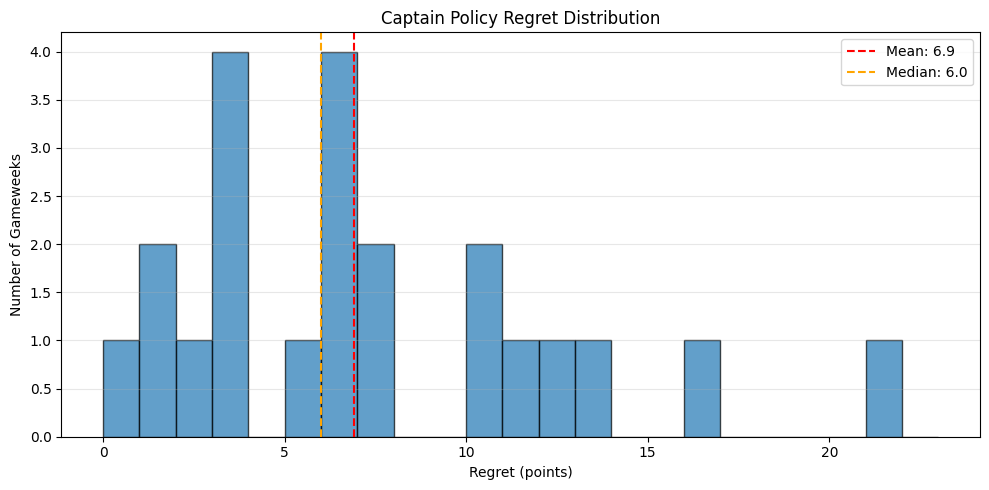

In [3]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(eval_df["regret"], bins=range(0, int(eval_df["regret"].max()) + 3), 
        edgecolor="black", alpha=0.7)
ax.axvline(eval_df["regret"].mean(), color="red", linestyle="--", 
           label=f"Mean: {eval_df['regret'].mean():.1f}")
ax.axvline(eval_df["regret"].median(), color="orange", linestyle="--", 
           label=f"Median: {eval_df['regret'].median():.1f}")

ax.set_xlabel("Regret (points)")
ax.set_ylabel("Number of Gameweeks")
ax.set_title("Captain Policy Regret Distribution")
ax.legend()
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## Plot 2 — Chosen vs Optimal Points

This scatter plot compares the chosen captain's actual points against the optimal captain's points. Points on the diagonal line represent perfect decisions (zero regret). The vertical distance from the diagonal represents regret.

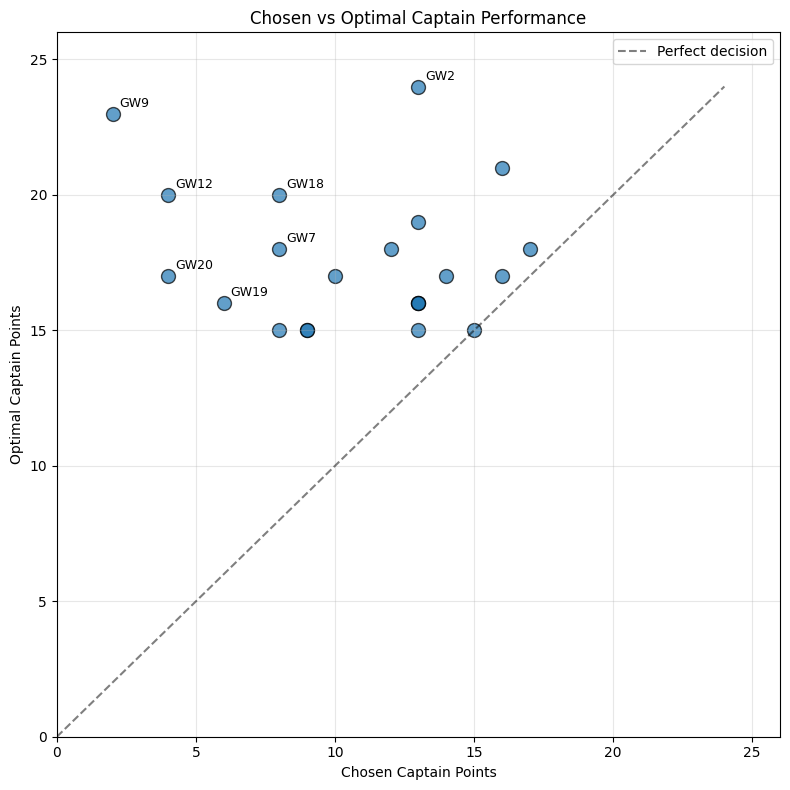

In [4]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(eval_df["chosen_points"], eval_df["optimal_points"], 
           s=100, alpha=0.7, edgecolor="black")

# Perfect decision line
max_pts = max(eval_df["optimal_points"].max(), eval_df["chosen_points"].max())
ax.plot([0, max_pts], [0, max_pts], "k--", label="Perfect decision", alpha=0.5)

# Annotate high-regret GWs
high_regret = eval_df[eval_df["regret"] >= 10]
for _, row in high_regret.iterrows():
    ax.annotate(f"GW{row['gw']}", (row["chosen_points"], row["optimal_points"]),
                textcoords="offset points", xytext=(5, 5), fontsize=9)

ax.set_xlabel("Chosen Captain Points")
ax.set_ylabel("Optimal Captain Points")
ax.set_title("Chosen vs Optimal Captain Performance")
ax.legend()
ax.grid(alpha=0.3)
ax.set_xlim(0, max_pts + 2)
ax.set_ylim(0, max_pts + 2)
plt.tight_layout()
plt.show()

## 6a Observations

**Mean regret: 6.91 pts/GW** — Is this good? We don't know yet. We need baselines.

### Why Non-Zero Regret is Unavoidable

The optimal captain is determined by **realized outcomes**. This is unknowable before matches. A rational policy maximizes expected value, which helps long-run returns but cannot guarantee single-GW perfection.

### Large Regrets = Rare Haul Events

High-regret GWs (10+) occur when a player we didn't pick has an unexpected haul. Hauls are rare (~4.5% of appearances) and hard to predict — the `p_haul` model couldn't beat the base rate.

### Decision Quality ≠ Outcome

A good decision can have a bad outcome. If we pick a player with 5 expected points and they score 2, the decision was still correct given available information. Over many GWs, low mean regret indicates good decision-making.

---

# Part 6b — Baseline Comparison

The original policy achieved **6.91 mean regret**. But is that good or bad? We need baselines.

## Baselines Tested

| Policy | Score Formula | Rationale |
|--------|---------------|-----------|
| **Baseline A** | `mu_points` only | Pure upside, ignore availability |
| **Baseline B** | `p_play` only | Pure availability, ignore upside |
| **Baseline C** | `points_per_90_5` | Historical PPG, no model |

In [8]:
# Load baseline comparison results
baselines_df = pd.read_csv("../storage/datasets/evaluation_captain_baselines.csv")

# Load original policy results for comparison
original_df = eval_df.copy()

# Extract regret by policy (use actual policy names from CSV)
baseline_a = baselines_df[baselines_df["policy_name"] == "baseline_a_mu_points"]["regret"]
baseline_b = baselines_df[baselines_df["policy_name"] == "baseline_b_p_play"]["regret"]
baseline_c = baselines_df[baselines_df["policy_name"] == "baseline_c_points_per_90"]["regret"]

# Create comparison summary
policies = {
    "6a_original (p_play × mu_points)": original_df["regret"],
    "baseline_a (mu_points)": baseline_a,
    "baseline_b (p_play)": baseline_b,
    "baseline_c (points_per_90)": baseline_c,
}

comparison = pd.DataFrame({
    "Policy": list(policies.keys()),
    "Mean Regret": [r.mean() for r in policies.values()],
    "Median Regret": [r.median() for r in policies.values()],
    "% GW ≥ 10": [f"{(r >= 10).mean():.1%}" for r in policies.values()],
}).sort_values("Mean Regret")

print("Policy Comparison (sorted by mean regret):")
print("=" * 60)
print(comparison.to_string(index=False))
print("=" * 60)

Policy Comparison (sorted by mean regret):
                          Policy  Mean Regret  Median Regret % GW ≥ 10
          baseline_a (mu_points)     6.227273            6.0     22.7%
6a_original (p_play × mu_points)     6.909091            6.0     31.8%
             baseline_b (p_play)    14.045455           14.0     81.8%
      baseline_c (points_per_90)    16.863636           16.5     95.5%


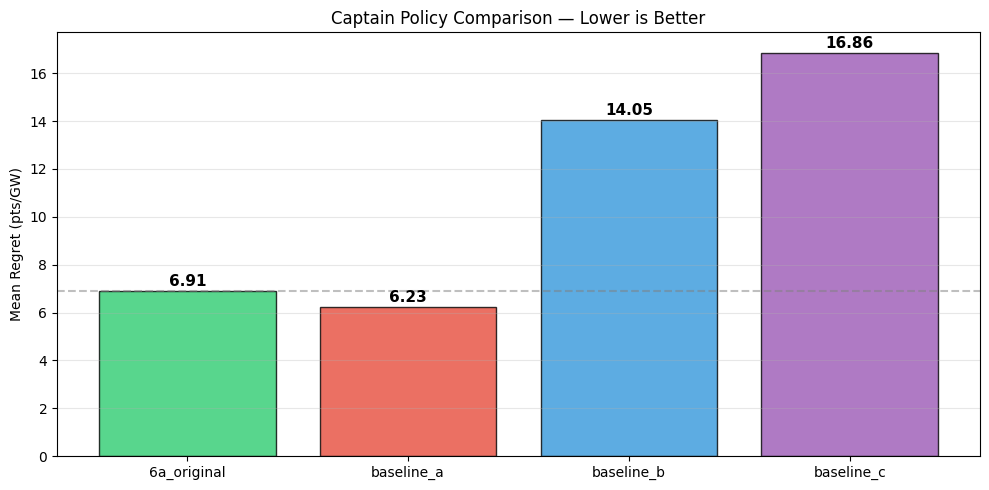

In [12]:
# Visual comparison
fig, ax = plt.subplots(figsize=(10, 5))

colors = ["#2ecc71", "#e74c3c", "#3498db", "#9b59b6"]
means = [policies[k].mean() for k in policies.keys()]
labels = [k.split(" ")[0] for k in policies.keys()]

bars = ax.bar(labels, means, color=colors, edgecolor="black", alpha=0.8)

# Add value labels
for bar, val in zip(bars, means):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, 
            f"{val:.2f}", ha="center", fontsize=11, fontweight="bold")

ax.set_ylabel("Mean Regret (pts/GW)")
ax.set_title("Captain Policy Comparison — Lower is Better")
ax.axhline(y=means[0], color="gray", linestyle="--", alpha=0.5, label="Original policy")
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## 6b Finding: We Were Wrong

**Baseline A (mu_points only) beats the original policy.**

| Policy | Mean Regret |
|--------|-------------|
| baseline_a (mu_points) | **6.23** |
| 6a_original (p_play × mu_points) | 6.91 |

The availability weighting made things **worse**, not better.

Why? Captain candidates are typically nailed-on starters. Their `p_play` values are ~0.95+, so the multiplier just dampens the upside signal without providing protection against rotation.

**For captaincy, upside dominates availability.**

---

# Part 6c — Policy Revision

## Reflection

| | |
|---|---|
| **What we assumed** | Weighting by `p_play` protects against rotation risk |
| **What evidence showed** | `mu_points` alone has 0.68 pts/GW lower regret |
| **Why it failed** | Captain candidates already have p_play ≈ 0.95+ |
| **Correction** | Use `score = mu_points` for captain selection |

See `docs/stage_6_reflection.md` for the full documented correction.

In [13]:
# Load revised policy results
revised_df = pd.read_csv("../storage/datasets/evaluation_captain_revised.csv")

# Final comparison: Original vs Revised
print("Policy Revision Results")
print("=" * 60)
print(f"{'Metric':<25} {'Original':>12} {'Revised':>12}")
print("-" * 60)

metrics_compare = [
    ("Mean regret", original_df["regret"].mean(), revised_df["regret"].mean()),
    ("Median regret", original_df["regret"].median(), revised_df["regret"].median()),
    ("% GW ≥ 10 regret", f"{(original_df['regret'] >= 10).mean():.1%}", 
     f"{(revised_df['regret'] >= 10).mean():.1%}"),
    ("Total regret", original_df["regret"].sum(), revised_df["regret"].sum()),
]

for name, orig, rev in metrics_compare:
    if isinstance(orig, float):
        print(f"{name:<25} {orig:>12.2f} {rev:>12.2f}")
    else:
        print(f"{name:<25} {orig:>12} {rev:>12}")

improvement = original_df["regret"].mean() - revised_df["regret"].mean()
print("-" * 60)
print(f"\n✅ Revised policy saves {improvement:.2f} pts/GW")

Policy Revision Results
Metric                        Original      Revised
------------------------------------------------------------
Mean regret                       6.91         6.23
Median regret                     6.00         6.00
% GW ≥ 10 regret                 31.8%        22.7%
Total regret                       152          137
------------------------------------------------------------

✅ Revised policy saves 0.68 pts/GW


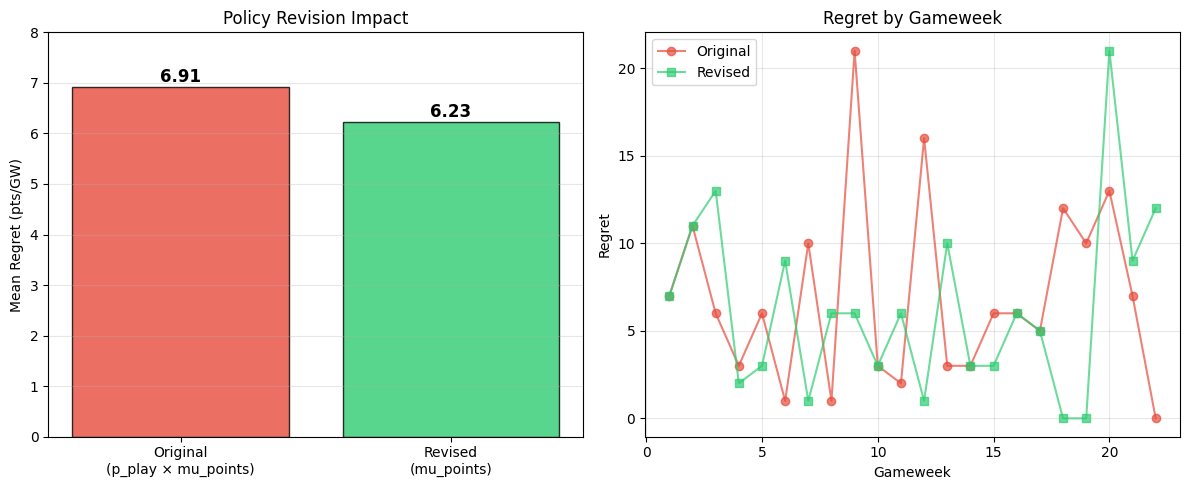

In [14]:
# Visual: Before vs After
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar comparison
ax1 = axes[0]
policies_final = ["Original\n(p_play × mu_points)", "Revised\n(mu_points)"]
means_final = [original_df["regret"].mean(), revised_df["regret"].mean()]
colors_final = ["#e74c3c", "#2ecc71"]
bars = ax1.bar(policies_final, means_final, color=colors_final, edgecolor="black", alpha=0.8)
for bar, val in zip(bars, means_final):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f"{val:.2f}", ha="center", fontsize=12, fontweight="bold")
ax1.set_ylabel("Mean Regret (pts/GW)")
ax1.set_title("Policy Revision Impact")
ax1.set_ylim(0, 8)
ax1.grid(axis="y", alpha=0.3)

# GW-by-GW comparison
ax2 = axes[1]
gws = original_df["gw"]
ax2.plot(gws, original_df["regret"], "o-", label="Original", color="#e74c3c", alpha=0.7)
ax2.plot(gws, revised_df["regret"], "s-", label="Revised", color="#2ecc71", alpha=0.7)
ax2.set_xlabel("Gameweek")
ax2.set_ylabel("Regret")
ax2.set_title("Regret by Gameweek")
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

---

# Summary

## Stage 6 Progression

| Stage | Policy | Mean Regret | Status |
|-------|--------|-------------|--------|
| 6a | `p_play × mu_points` | 6.91 | ❌ Superseded |
| 6b | Baselines tested | — | — |
| 6c | `mu_points` | **6.23** | ✅ Current |

## Key Lessons

1. **Test assumptions** — The p_play weighting seemed logical but hurt performance
2. **Baselines reveal truth** — Without baseline_a, we'd think 6.91 was good
3. **Upside > availability** — For captaincy, pick the best scorer; they're already starters

## Final Captain Policy

```python
def captain_score(player):
    return player["mu_points"]  # Pure upside
```

## Artifacts

| File | Description |
|------|-------------|
| `evaluation_captain.csv` | Original policy (6a) |
| `evaluation_captain_baselines.csv` | Baseline comparison (6b) |
| `evaluation_captain_revised.csv` | Revised policy (6c) |
| `docs/stage_6_reflection.md` | Evidence-based correction |